In [271]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import tensorflow as tf

#Usare scaler

# Prepare and Review Dataset

In [272]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


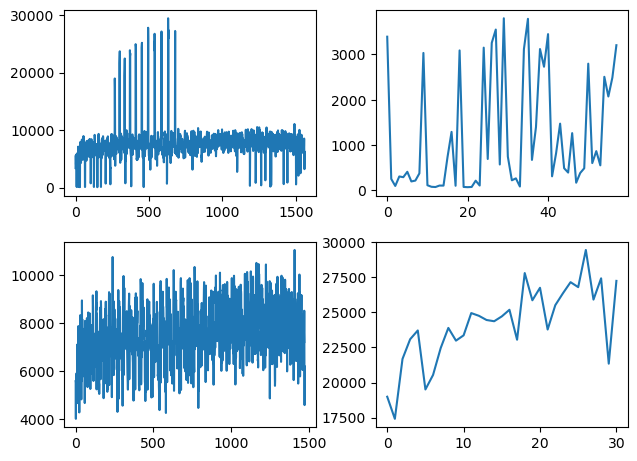

In [273]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [274]:
Resa3Medium = Resa3Medium/Resa3Medium.max()

1185


(array([ 1.,  4.,  3.,  4., 10., 14., 18., 23., 26., 28., 19., 11., 16.,
        25., 24., 25., 27., 34., 25., 27., 23., 33., 25., 22., 15., 18.,
        32., 44., 26., 19., 10.,  5.,  3.,  1.,  1.,  1.]),
 array([0.36391   , 0.38157916, 0.39924833, 0.4169175 , 0.43458664,
        0.45225582, 0.469925  , 0.48759416, 0.5052633 , 0.52293247,
        0.5406017 , 0.5582708 , 0.57594   , 0.59360915, 0.61127836,
        0.6289475 , 0.64661664, 0.66428584, 0.681955  , 0.6996242 ,
        0.7172933 , 0.7349625 , 0.75263166, 0.7703008 , 0.78797   ,
        0.80563915, 0.82330835, 0.8409775 , 0.8586467 , 0.87631583,
        0.893985  , 0.9116542 , 0.9293233 , 0.9469925 , 0.96466166,
        0.98233086, 1.        ], dtype=float32),
 <a list of 36 Patch objects>)

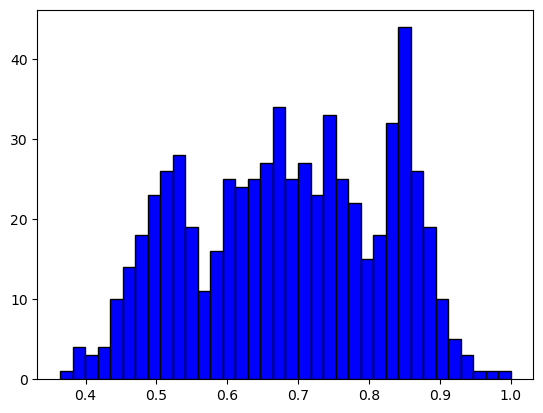

In [296]:

Resa3Undesampling = (Resa3Medium>=0.55) & (Resa3Medium<=0.83)

trueList = np.argwhere(Resa3Undesampling == True).flatten()
print(trueList.shape[0])
falseList = np.argwhere(Resa3Undesampling == False).flatten()
flipToFalse = np.random.choice(range(trueList.shape[0]), size=(int(trueList.shape[0]*0.3),), replace=False)

SampleList = np.concatenate((falseList,trueList[flipToFalse]))

Resa3Sampled = Resa3Medium[SampleList]
Pixel3Sampled = Pixel3Medium[SampleList,:,:]
import seaborn as sns
plt.hist(Resa3Sampled, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [276]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]*0.8),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

# Costruisco le immagini

[0.5210141  0.47243312 0.4654555  0.5161786  0.38800615 0.47504517
 0.5714389  0.5474331  0.44616774 0.56777835]


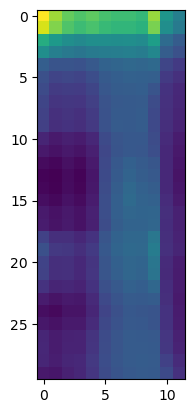

In [277]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"
predict_path = "dataset\\predict\\0\\"


#training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Sampled,Resa3Sampled)
#training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

#training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
#training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)
training_setX = training_setMediumX
training_setY = training_setMediumY

#test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
#test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')
    img.save(predict_path+str(a)+'.tiff')


In [278]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY
print(dFTrain.head())
input_shape = (160,160)
# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = input_shape,
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = input_shape,
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.505640
1  1.tiff  0.498988
2  2.tiff  0.363910
3  3.tiff  0.535213
4  4.tiff  0.507628
Found 670 validated image filenames.
Found 168 validated image filenames.


In [279]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())


0.6764216423034668
0.6758722066879272
0.683761477470398
0.6818329691886902


# Creazione del modello di Vgg16

In [280]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape+(3,),
                                               include_top=False,
                                               weights='imagenet')

In [281]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_9[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [282]:
base_model.trainable = False
# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [283]:
model = Sequential()

In [284]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu'))
model.add(Dense(1,activation='linear'))


In [285]:
base_learning_rate = 0.01

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.Adam(base_learning_rate), 
              metrics=['mse', 'mae', 'mape'])

In [286]:
len(model.trainable_variables)

4

In [287]:
# After I added last layer in created model.
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_8 (Flatten)         (None, 32000)             0         
                                                                 
 dense_17 (Dense)            (None, 2048)              65538048  
                                                                 
 dense_18 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 67,798,081
Trainable params: 65,540,097
Non-trainable params: 2,257,984
_________________________________________________________________


In [288]:
# I create compile part.
model.compile(loss = "mean_squared_error",
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-03),
             metrics = ["mse","mae"])

# Training Model 

In [289]:
# Traning with model
batch_size = 32

hist_model = model.fit(train_data, 
                                epochs = 30,
                                validation_data=test_data
                                )

Epoch 1/30
21/21 [==============================] - 16s 629ms/step - loss: 26452.4531 - mse: 26452.4531 - mae: 39.2745 - val_loss: 0.1748 - val_mse: 0.1748 - val_mae: 0.3239
Epoch 2/30
21/21 [==============================] - 12s 589ms/step - loss: 5.8403 - mse: 5.8403 - mae: 1.4737 - val_loss: 0.1001 - val_mse: 0.1001 - val_mae: 0.2587
Epoch 3/30
21/21 [==============================] - 12s 590ms/step - loss: 3.3314 - mse: 3.3314 - mae: 1.1244 - val_loss: 0.1015 - val_mse: 0.1015 - val_mae: 0.2628
Epoch 4/30
21/21 [==============================] - 12s 585ms/step - loss: 1.8339 - mse: 1.8339 - mae: 0.8919 - val_loss: 0.0729 - val_mse: 0.0729 - val_mae: 0.2296
Epoch 5/30
21/21 [==============================] - 13s 597ms/step - loss: 0.9253 - mse: 0.9253 - mae: 0.6047 - val_loss: 0.2039 - val_mse: 0.2039 - val_mae: 0.4283
Epoch 6/30
21/21 [==============================] - 13s 597ms/step - loss: 0.3795 - mse: 0.3795 - mae: 0.3836 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1237
E

In [290]:
# Save the weights of model
#vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

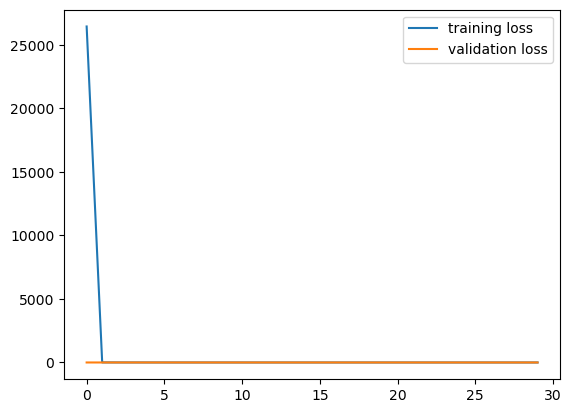

In [291]:

# Loss and Validation Loss

plt.plot(hist_model.history["loss"], label = "training loss")
plt.plot(hist_model.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

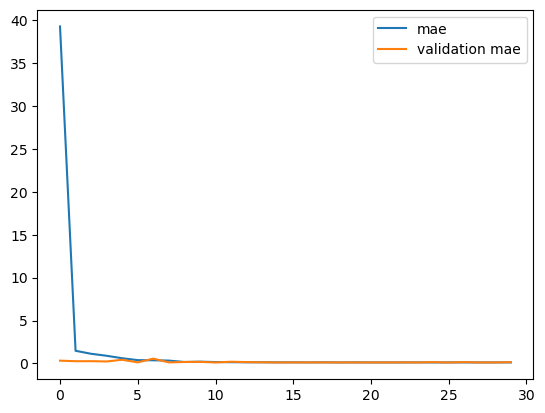

In [292]:
# Accuracy and Validation Accuracy
plt.plot(hist_model.history["mae"], label = "mae")
plt.plot(hist_model.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [293]:
import os
import glob


predict_path = "dataset\\predict\\"

files = glob.glob(predict_path+'\\0\\*')
for f in files:
    os.remove(f)

true_y = dFTest['target'].values
print(len(true_y))
#index = np.where(true_y == true_y.max())[0][0]
#print(index)
#if index != 0:
#    indexRange = range(index-1,index+2)
#else:
#    indexRange = range(0,index+3)
#for a in indexRange:
#    img = Image.fromarray(test_setX[a,:,:])
#    img.save(predict_path+'\\0\\'+str(a)+'.tiff')


for a in range(len(true_y)):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(predict_path+'\\0\\'+str(a)+'.tiff')

predict_data = ImageDataGenerator().flow_from_directory(directory=predict_path,target_size=input_shape)


#print(dFTest['target'])                                                  
pred_y = model.predict(predict_data)



168
Found 168 images belonging to 1 classes.
6/6 [==============================] - 2s 198ms/step


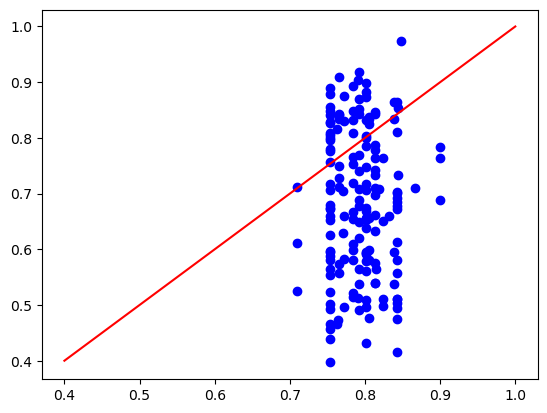

In [294]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

#
#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()

# Salviamo e carichiamo i risultati

In [161]:
'''import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)'''

'import json, codecs\nwith open("previsioneResa.json","w") as f:\n    json.dump(hist_vgg16.history, f)'

In [162]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [163]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [164]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [165]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)
vgg19Model.add(Flatten())

In [166]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [167]:
# Last layer
vgg19Model.add(Dense(512,activation='relu'))
vgg19Model.add(Dense(1,activation='sigmoid'))

In [168]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,287,553
Trainable params: 263,169
Non-trainable params: 20,024,384
_________________________________________________________________


In [169]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Addestramento

In [170]:
# Traning with model
batch_size = 32

# Training with my created model
'''hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 20,
                               validation_data = test_data
                               )'''

'hisy_vgg19 = vgg19Model.fit_generator(train_data,\n                               epochs = 20,\n                               validation_data = test_data\n                               )'

# Visualizziamo i risultati ottenuti

In [80]:
# Loss And Validation Loss
'''plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()'''

'plt.plot(hisy_vgg19.history["loss"], label = "training loss")\nplt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")\nplt.legend()\nplt.show()'

In [81]:
# Accuracy And Validation Accuracy
'''plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()'''

'plt.plot(hisy_vgg19.history["mae"], label = "mae")\nplt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")\nplt.legend()\nplt.show()'

In [82]:
val = dFTest['target'].values
print(len(val))
print(np.where(val == 1.0))

736
(array([], dtype=int64),)


In [85]:
predict_path = "dataset\\predict\\"
real = [0.7098427508416938,0.7070679681851049,0.560891196250226,0.756299728426654,0.6950921908893709]
predict_data = ImageDataGenerator().flow_from_directory(directory=predict_path,target_size=(160,160))

val = dFTest['target'].values
#print(len(val))
#print(np.where(val == 1.0))
#print(dFTest['target'].where(1.0))
print(dFTest['target'][711:714])
print(dFTest['target'].mean())                                                    
prediction = model.predict(predict_data)
print(prediction)                                         

Found 736 images belonging to 1 classes.
711    0.684490
712    0.836885
713    0.496737
Name: target, dtype: float32
0.6918872594833374
23/23 [==============================] - 5s 191ms/step
[[0.74484265]
 [0.729233  ]
 [0.80082697]
 [0.76422524]
 [0.76422524]
 [0.75377536]
 [0.7768774 ]
 [0.76790583]
 [0.7641871 ]
 [0.77949077]
 [0.755401  ]
 [0.74908876]
 [0.7637865 ]
 [0.7813547 ]
 [0.7591142 ]
 [0.73881304]
 [0.7734996 ]
 [0.73374796]
 [0.77949077]
 [0.788865  ]
 [0.755401  ]
 [0.7329864 ]
 [0.75205374]
 [0.77039415]
 [0.7643129 ]
 [0.7727712 ]
 [0.76790583]
 [0.74484265]
 [0.7965219 ]
 [0.7499074 ]
 [0.78211987]
 [0.7473288 ]
 [0.7363662 ]
 [0.729233  ]
 [0.7858438 ]
 [0.76422524]
 [0.76302755]
 [0.7701602 ]
 [0.755401  ]
 [0.77560693]
 [0.7525336 ]
 [0.7315088 ]
 [0.8069184 ]
 [0.729233  ]
 [0.79036236]
 [0.8013243 ]
 [0.7734996 ]
 [0.752818  ]
 [0.76757133]
 [0.7482028 ]
 [0.7698562 ]
 [0.7667401 ]
 [0.76986927]
 [0.729233  ]
 [0.7741977 ]
 [0.7591142 ]
 [0.7810625 ]
 [0.775606

(736, 1)
(736,)


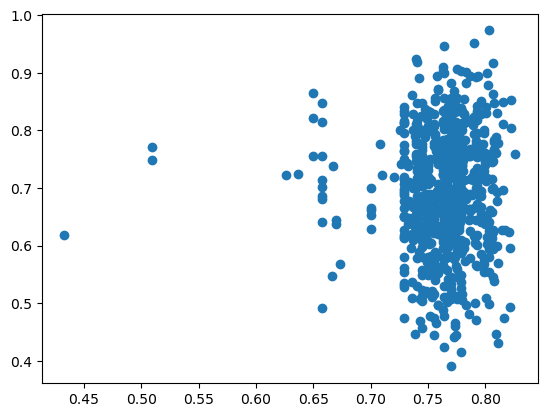

In [86]:
print(prediction.shape)
print(training_setY.shape)
plt.scatter(prediction[:,0],test_setY/Resa3Medium.max())